In [1]:
import sys
assert sys.version_info >= (3, 5)

In [2]:
import sklearn
assert sklearn.__version__ >= "0.2"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import os
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'Chapter 7'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting Classifiers

In [4]:
np.random.seed(42)
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

#### Figure 7-3. The law of large numbers

Saving figure law_of_large_numbers_plot


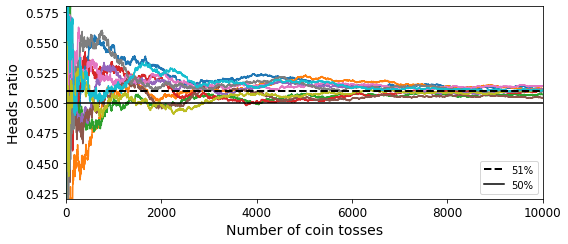

In [5]:
plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], 'k--', linewidth=2, label='51%')
plt.plot([0, 10000], [0.5, 0.5], 'k-', label='50%')
plt.xlabel('Number of coin tosses')
plt.ylabel('Heads ratio')
plt.legend(loc='lower right')
plt.axis([0, 10000, 0.42, 0.58])
plt.yticks([0.425, 0.45, 0.475, 0.5, 0.525, 0.55, 0.575])

save_fig('law_of_large_numbers_plot')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

lr_clf = LogisticRegression(random_state=42) # default : solver='lbfgs'
rf_clf = RandomForestClassifier(random_state=42) # default : n_estimators=100
svm_clf = SVC(random_state=42) # default : gamma='scale'

voting_clf = VotingClassifier(estimators=[
    ('lr', lr_clf),
    ('rf', rf_clf),
    ('svc', svm_clf)], voting='hard')

In [8]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [9]:
from sklearn.metrics import accuracy_score

for clf in (lr_clf, rf_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, ":", accuracy_score(y_test, y_pred))

LogisticRegression : 0.864
RandomForestClassifier : 0.896
SVC : 0.896
VotingClassifier : 0.912


In [10]:
# Case : soft voting(Not hard)
# if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities

lr_clf = LogisticRegression(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42) # 클래스 확률 제공

voting_clf = VotingClassifier(estimators=[
    ('lr', lr_clf),
    ('rf', rf_clf),
    ('svc', svm_clf)], voting='soft')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [11]:
for clf in (lr_clf, rf_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, ":", accuracy_score(y_test, y_pred))

LogisticRegression : 0.864
RandomForestClassifier : 0.896
SVC : 0.896
VotingClassifier : 0.92


# Bagging and Pasting

## Bagging and Pasting in Scikit-learn

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=500,
                           max_samples=100,
                           bootstrap=True, # default bootstrap=True
                           random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, random_state=42)

In [13]:
y_pred = bag_clf.predict(X_test)
print("BaggingClassifier :", accuracy_score(y_pred, y_test))

BaggingClassifier : 0.904


In [14]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
print('DeicisionTreeClassifier :', accuracy_score(y_test, y_pred))

DeicisionTreeClassifier : 0.856


#### Figure 7-5. A Single Decision Tree(left) vs A Bagging Ensemble of 500 Trees(right)

In [15]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel('$x_1$', fontsize=18)
    plt.ylabel("$x_2$", rotation=0, fontsize=18)

Saving figure decision_tree_without_and_with_bagging_plot


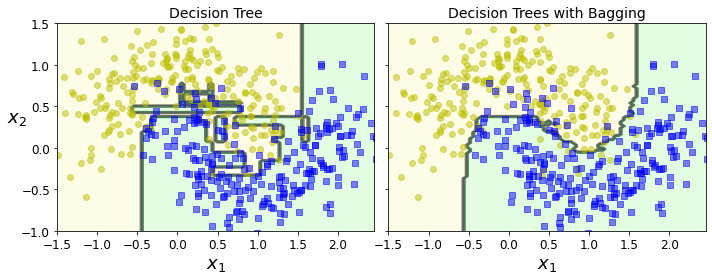

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

save_fig('decision_tree_without_and_with_bagging_plot')
plt.show()

## Out-of-Bag evaluation

In [17]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                          n_estimators=500,
                          bootstrap=True,
                          oob_score=True,
                          random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [18]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [19]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

# Random Forest

In [20]:
rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

In [21]:
# BaggingClassifier를 사용하여 RandomForestClassifier와 유사하게 만든 Model
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16),
                           n_estimators=500, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

In [22]:
np.sum(y_pred_bag == y_pred_rf) / len(y_pred_bag)

1.0

## Feature Importance

In [23]:
from sklearn.datasets import load_iris

iris = load_iris()
rf_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rf_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rf_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


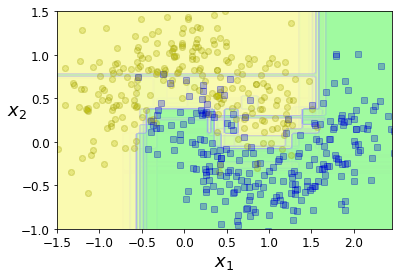

In [24]:
# 15개 Decision Tree의 결정 경계를 겹쳐서 표현한 그림
plt.figure(figsize=(6, 4))

for i in range(15):
    dt_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    dt_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    
    plot_decision_boundary(dt_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)
    
plt.show()

#### Figure 7-6. MNIST pixel importance (according to a RandomForestClassifier)

In [25]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [26]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(random_state=42)

In [27]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.hot, interpolation='nearest')
    plt.axis('off')

Saving figure mnist_feature_importance_plot


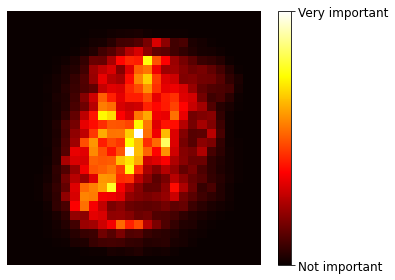

In [28]:
plot_digit(rf_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rf_clf.feature_importances_.min(), rf_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig('mnist_feature_importance_plot')
plt.show()

# Boosting

## AdaBoost

In [29]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,
                            algorithm='SAMME.R', learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

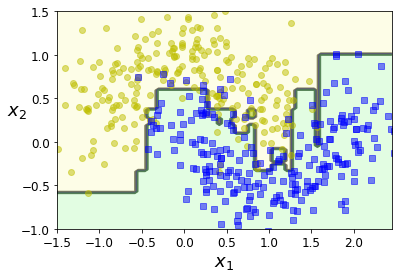

In [30]:
plot_decision_boundary(ada_clf, X, y)

#### Figure 7-8. Decision boundaries of consecutive predictors

Saving figure boosting_plot


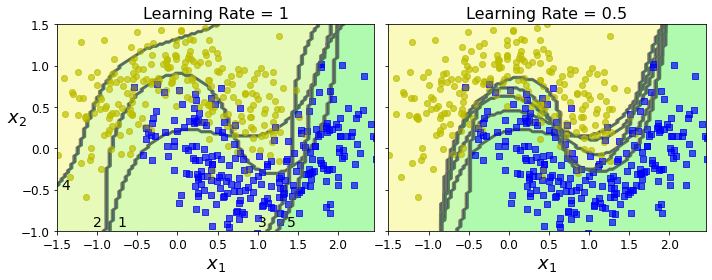

In [31]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    
    for i in range(5):
        svm_clf = SVC(kernel='rbf', C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # 식 7-1
        alpha = learning_rate * np.log((1-r) / r) # 식 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # 식 7-3
        sample_weights /= sample_weights.sum() # 정규화
        
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title(f'Learning Rate = {learning_rate}', fontsize=16)
        
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36, -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")
        
save_fig('boosting_plot')
plt.show()

## Gradient Boosting

In [32]:
# simple quadratic dataset
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05*np.random.randn(100)

In [33]:
from sklearn.tree import DecisionTreeRegressor

dt_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
dt_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [34]:
y2 = y - dt_reg1.predict(X)
dt_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
dt_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [35]:
y3 = y2 - dt_reg2.predict(X)
dt_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
dt_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [36]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (dt_reg1, dt_reg2, dt_reg3))
y_pred

array([0.75026781])

#### Figure 7-9. (Top Left) : First predictor is trained normally (Middle Left & Lower Left) : Each consecutive predictor is trained on the previous predictor's residuals (Right Column) Resulting ensemble's predictions

In [37]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for  regressor in regressors)
    
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc='upper center', fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


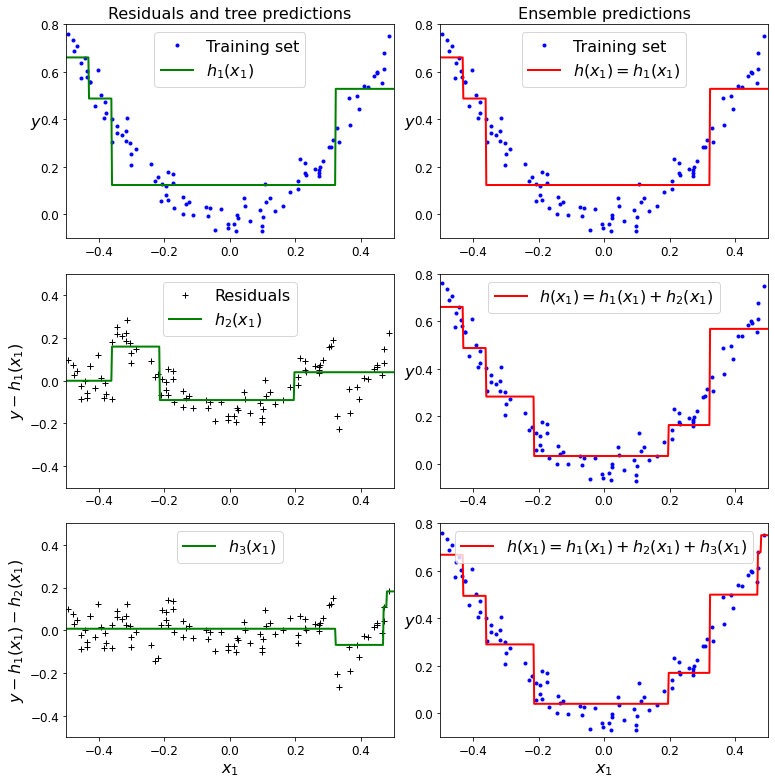

In [38]:
plt.figure(figsize=(11, 11))

plt.subplot(321)
plot_predictions([dt_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.title('Residuals and tree predictions', fontsize=16)

plt.subplot(322)
plot_predictions([dt_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", rotation=0, fontsize=16)
plt.title('Ensemble predictions', fontsize=16)

plt.subplot(323)
plot_predictions([dt_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel('$y - h_1(x_1)$', fontsize=16)

plt.subplot(324)
plot_predictions([dt_reg1, dt_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='$h(x_1) = h_1(x_1) + h_2(x_1)$')
plt.ylabel('$y$', rotation=0, fontsize=16)

plt.subplot(325)
plot_predictions([dt_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label='$h_3(x_1)$', style="g-", data_style='k+')
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$y - h_1(x_1) - h_2(x_1)$', fontsize=16)

plt.subplot(326)
plot_predictions([dt_reg1, dt_reg2, dt_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$')
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)

save_fig('gradient_boosting_plot')
plt.show()

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

#### Figure 7-10. GBRT ensembles with not enough predictors(left) and too many(right)

In [40]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate


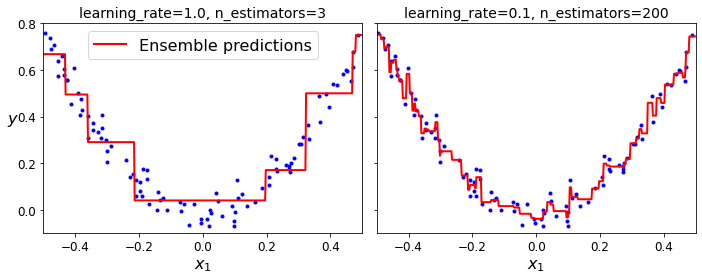

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='Ensemble predictions')
plt.title(f'learning_rate={gbrt.learning_rate}, n_estimators={gbrt.n_estimators}', fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", rotation=0, fontsize=16)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f'learning_rate={gbrt_slow.learning_rate}, n_estimators={gbrt_slow.n_estimators}', fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig('gbrt_learning_rate')
plt.show()

In [42]:
# gbrt with EarlyStopping
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

In [43]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)

In [44]:
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

In [45]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

#### 7-11. Tuning the number of trees using early stopping

In [46]:
min_error =np.min(errors)

Saving figure early_stopping_gbrt_plot


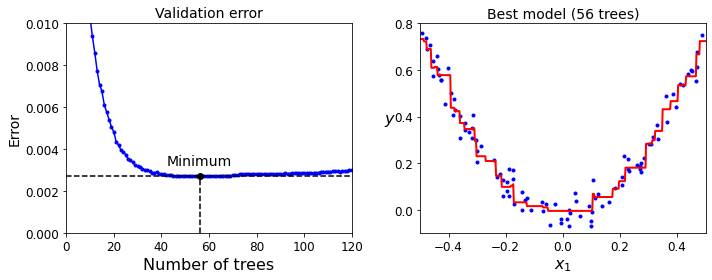

In [47]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, 'b.-')
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], 'k--')
plt.plot([0, 120], [min_error, min_error], 'k--')
plt.plot(bst_n_estimators, min_error, 'ko')
plt.text(bst_n_estimators, min_error*1.2, 'Minimum', ha='center', fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.title("Validation error", fontsize=14)
plt.xlabel('Number of trees', fontsize=16)
plt.ylabel('Error', fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f'Best model ({bst_n_estimators} trees)', fontsize=14)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel("$y$", rotation=0, fontsize=16)

save_fig('early_stopping_gbrt_plot')
plt.show()

In [48]:
# Early stopping with some patience
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float('inf')
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # 조기종료

In [49]:
print(gbrt.n_estimators)

61


In [50]:
print('Minimum Validation MSE :', min_val_error)

Minimum Validation MSE : 0.002712853325235463


In [51]:
# Using xgboost
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [52]:
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print('Validation MSE :', val_error)

Validation MSE : 0.004000408205406276


In [53]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155


C:\Users\82104\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [54]:
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE :", val_error)

Validation MSE : 0.002630868681577655


In [55]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

23.4 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [56]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

19.3 ms ± 997 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
